In [25]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes


In [26]:
data_root = '/nuscenes_CLEAN'
nusc = NuScenes(version='v1.0-trainval', dataroot=data_root, verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 30.373 seconds.
Reverse indexing ...
Done reverse indexing in 9.0 seconds.


In [27]:
from collections import OrderedDict
from typing import List, Tuple, Union

import numpy as np
from pyquaternion.quaternion import Quaternion
from shapely.geometry import MultiPoint, box
from tqdm import tqdm

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points

import cv2
import numpy as np
from matplotlib import pyplot as plt

def post_process_coords(corner_coords: List,
                        imsize: Tuple[int, int] = (1600, 900)) -> Union[Tuple[float, float, float, float], None]:
    """
    Get the intersection of the convex hull of the reprojected bbox corners and the image canvas, return None if no
    intersection.
    :param corner_coords: Corner coordinates of reprojected bounding box.
    :param imsize: Size of the image canvas.
    :return: Intersection of the convex hull of the 2D box corners and the image canvas.
    """
    polygon_from_2d_box = MultiPoint(corner_coords).convex_hull
    img_canvas = box(0, 0, imsize[0], imsize[1])

    if polygon_from_2d_box.intersects(img_canvas):
        img_intersection = polygon_from_2d_box.intersection(img_canvas)
        intersection_coords = np.array([coord for coord in img_intersection.exterior.coords])

        min_x = min(intersection_coords[:, 0])
        min_y = min(intersection_coords[:, 1])
        max_x = max(intersection_coords[:, 0])
        max_y = max(intersection_coords[:, 1])

        return min_x, min_y, max_x, max_y
    else:
        return None

def camera_box(sd_tok, ann_tok):
    """
    Attempts to 3D->2D project ann_tok to sd_tok

    sd_tok: A sample_data token from a camera
    ann_tok: A sample_annotation token

    Returns: {
        'cam_name': cam (str),
        'cam_file': sd_rec['filename'] (str),
        'cam_2dbox_min_x': min_x (int),
        'cam_2dbox_min_y': min_y (int),
        'cam_2dbox_max_x': max_x (int),
        'cam_2dbox_max_y': max_y (int), 
    }, or None if the camera cannot see the annotation
    """
    # Project global box to cam
    global_box = nusc.get_box(ann_tok)
    sd_rec = nusc.get('sample_data', sd_tok)
    assert(sd_rec['sensor_modality'] == 'camera')
    cs_rec = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
    ego_pose_rec = nusc.get('ego_pose', sd_rec['ego_pose_token'])
    camera_intrinsic = np.array(cs_rec['camera_intrinsic'])
    # Move to the ego-pose frame.
    global_box.translate(-np.array(ego_pose_rec['translation']))
    global_box.rotate(Quaternion(ego_pose_rec['rotation']).inverse)
    # Move to the calibrated sensor frame.
    global_box.translate(-np.array(cs_rec['translation']))
    global_box.rotate(Quaternion(cs_rec['rotation']).inverse)
    # Filter out the corners that are not in front of the calibrated sensor.
    corners_3d = global_box.corners()
    in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
    corners_3d = corners_3d[:, in_front]

    # Project 3d box to 2d.
    corner_coords = view_points(corners_3d, camera_intrinsic, True).T[:, :2].tolist()

    # Keep only corners that fall within the image.
    final_coords = post_process_coords(corner_coords)

    # Skip if the convex hull of the re-projected corners does not intersect the image canvas.
    if final_coords is None:
        return None
    else:
        min_x, min_y, max_x, max_y = final_coords
        return {
            'cam_channel': sd_rec['channel'],
            'cam_file': sd_rec['filename'],
            'cam_min_x': min_x,
            'cam_min_y': min_y,
            'cam_max_x': max_x,
            'cam_max_y': max_y,
        }

def annotation_from_instance_sample(s_tok, i_tok):
    """
    Returns the annotation token of instance i_tok at sample s_tok
        the sample must contain the instance
    """
    ann = None
    for sample_ann_token in nusc.get('sample', s_tok)['anns']:
        sample_ann = nusc.get('sample_annotation', sample_ann_token)
        if sample_ann['instance_token'] == i_tok:
            assert ann is None, f"Found two annotations matching instance {i_tok} \
                in sample {s_tok}"
            ann = sample_ann
    assert ann is not None, f"Did not find instance {i_tok} in sample {s_tok}"
    return ann['token']

def best_channel(ann_tok, channel_pref=None):
    """
    Returns the best camera to view ann_tok from

    ann_tok: Annotation token to get the best view of
    channel_pref: If you can view ann_tok from this channel, do so
    """
    ann_rec = nusc.get('sample_annotation', ann_tok)
    sample_rec = nusc.get('sample', ann_rec['sample_token'])
    channels = [key for key in sample_rec['data'].keys() if 'CAM' in key]
    views = []
    for channel in channels:
        view = camera_box(sample_rec['data'][channel], ann_rec['token'])
        if view:
            views.append(view)
    # assert len(views) != 0, f"Cannot view annotation {ann_tok}"
    if len(views) == 0:
        return None
    if channel_pref is not None:
        pref_view = [v for v in views if v['cam_channel'] == channel_pref]
        if len(pref_view) > 0:
            assert len(pref_view) == 1
            return pref_view[0]
    def area(view):
        return (view['cam_max_x'] - view['cam_min_x']) * (view['cam_max_y'] - view['cam_min_y'])
    return sorted(views, key=area, reverse=True)[0]

def paint_view(img, view):
    # read image
    min_x = int(view['cam_min_x'])
    min_y = int(view['cam_min_y'])
    max_x = int(view['cam_max_x'])
    max_y = int(view['cam_max_y'])
    cv2.rectangle(img, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

def ann_img_and_channel(ann_rec, channel_pref=None):
    view = best_channel(ann_rec['token'],channel_pref)
    if view is None:
        return None, None
    img = cv2.imread(f"{data_root}/{view['cam_file']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    paint_view(img, view)
    return img, view['cam_channel']

def plot_sample(sample_token):
    img = None
    im_channel = None
    for ann_k in nusc.get('sample', sample_token)['anns']:
        ann = nusc.get('sample_annotation', ann_k)
        instance_token = ann['instance_token']
        ann_tok = annotation_from_instance_sample(sample_token, instance_token)
        best_view = best_channel(ann_tok)
        if best_view is None:
            continue
        if im_channel is not None and best_view['cam_channel'] != im_channel:
            continue
        if img is None:
            img = cv2.imread(f"{data_root}/{best_view['cam_file']}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im_channel = best_view['cam_channel']
        paint_view(img, best_view)
    return img
    # plt.imshow(img)
    # plt.show()

def plot_instance_hist(sample_token, instance_token, hist=5):
    curr_ann_tok = annotation_from_instance_sample(sample_token, instance_token)
    ann_rec = nusc.get('sample_annotation', curr_ann_tok)
    ann_rec_hist = [ann_rec]
    og_hist = hist
    hist-=1
    while ann_rec['prev'] and hist > 0:
        ann_rec = nusc.get('sample_annotation', ann_rec['prev'])
        ann_rec_hist.append(ann_rec)
        hist-=1
    if len(ann_rec_hist) != og_hist:
        print(f"Instance only has {len(ann_rec_hist)} length history, requested {hist} size")
    imgs = []
    curr_channel = None
    for ann_rec_i, ann_rec in enumerate(ann_rec_hist):
        img, channel = ann_img_and_channel(ann_rec, curr_channel)
        print(channel)
        if img is None:
            print(f"Instance cannot be viewed at history index {ann_rec_i}")
        imgs.append(img)
        curr_channel = channel
    return imgs
        
def show_imgs(imgs, dpi=100):
    # Determine the number of images and the number of rows and columns in the grid
    n_images = len(imgs)
    n_cols = 5
    n_rows = (n_images + n_cols - 1) // n_cols

    # Create a figure and a grid of subplots with the desired number of rows and columns
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(50, 50), dpi=dpi)

    # Iterate over the subplots and the images
    for ax, img in zip(axs.flat, imgs):
        # Display the image in the current subplot
        ax.imshow(img)

    # Remove the axis labels
    for ax in axs.flat:
        ax.axis('off')

    plt.show()
    
    

done gather, showing
CAM_BACK_RIGHT
CAM_BACK_RIGHT
CAM_FRONT_RIGHT
CAM_FRONT_RIGHT
CAM_FRONT_RIGHT


/opt/conda/envs/pgp/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


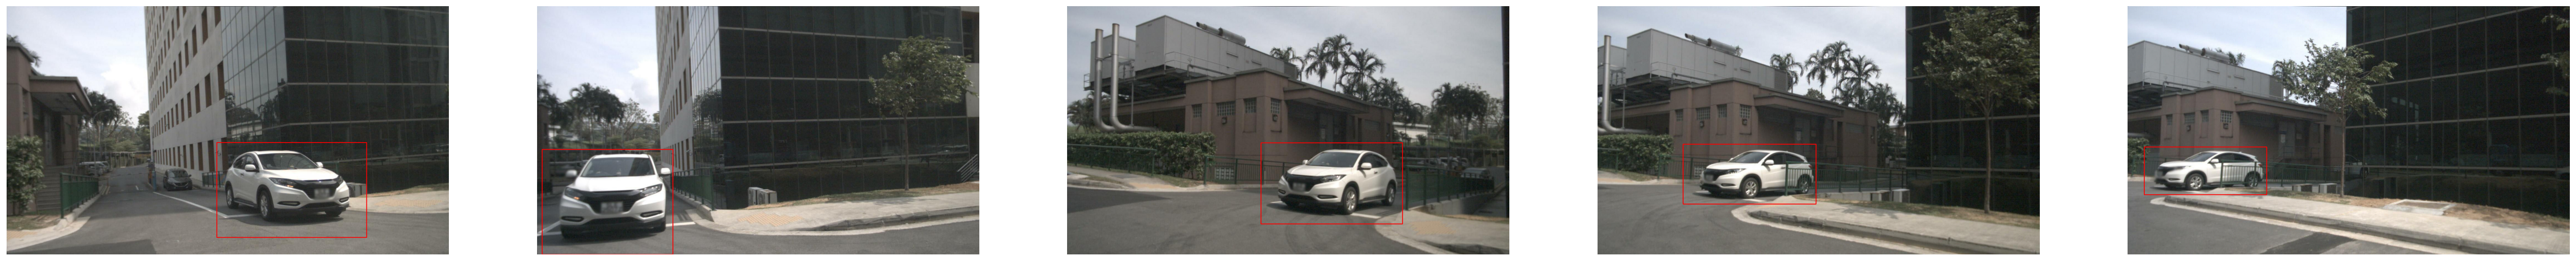

In [28]:
# my_instance = nusc.instance[500]
# last_annotation = nusc.get('sample_annotation', my_instance['last_annotation_token'])
# imgs = plot_instance_hist(last_annotation['sample_token'], last_annotation['instance_token'])
print("done gather, showing")
# show_imgs(imgs, 150)
show_imgs(plot_instance_hist('cef7b822dd33459e9874fed29cacf4c5', '8a6fe792c413423690d14a2d8513d803'), 150)

/opt/conda/envs/pgp/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


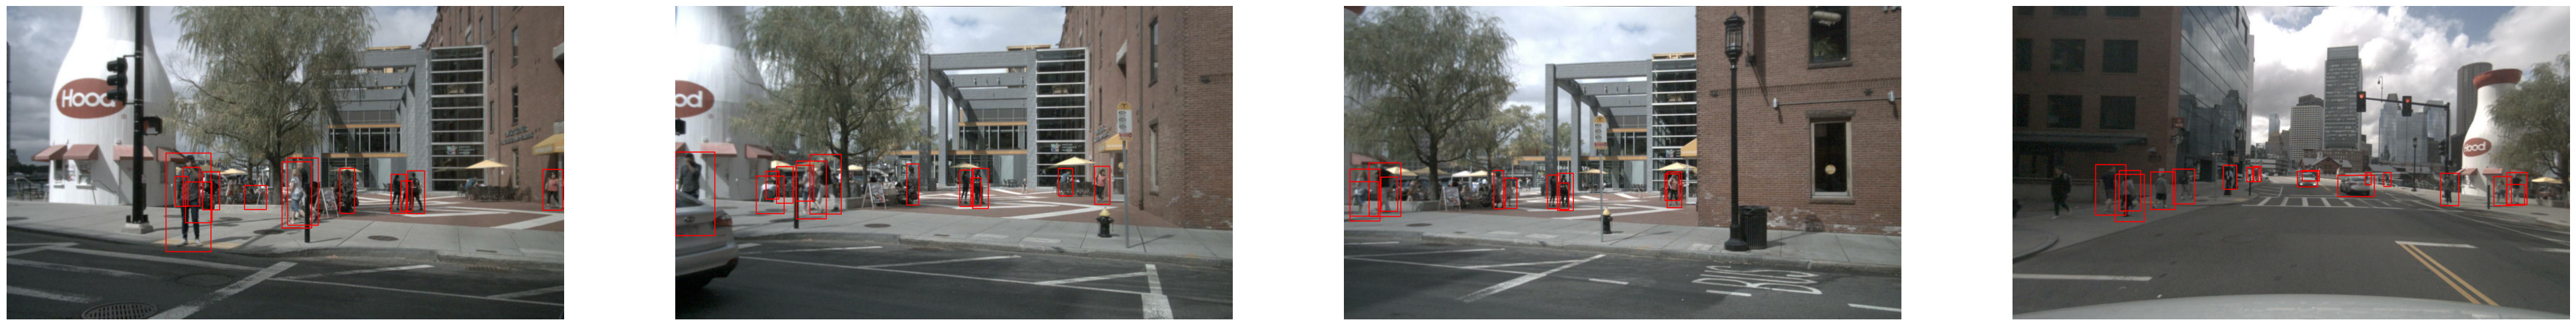

In [6]:
import numpy as np

scene = nusc.scene[1]
first_sample = nusc.get('sample', scene['first_sample_token'])
sample_tokens = []
while True:
    sample_tokens.append(first_sample['token'])
    if not first_sample['next']:
        break
    first_sample = nusc.get('sample', first_sample['next'])


imgs = [plot_sample(st) for st in sample_tokens[8:(8+4)]]
show_imgs(imgs)




In [19]:
# nusc.render_annotation('e75ae6e56c264e1691e21e244265a8e9')